In [2]:
import pandas as pd
import numpy as np
from datetime import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [13]:


def DATE_PROCESSING(TIMEZONE, YEAR, COIN):
    ROOT                = (r'/Users/westhomas/Desktop/PYTHON/CRYPTO PROJECT/INPUT FILES/INDICATORS')
    
    if YEAR == '2022': df_interval_starting = pd.read_csv(ROOT + '/INDICATORS - 1 DAY PER 15 MIN - ' + COIN + '.csv') 
    else:              df_interval_starting = pd.read_csv(ROOT + '/INDICATORS - 1 DAY PER 15 MIN - 2023 ONLY - ' + COIN + '.csv')

    
    df_interval_starting = df_interval_starting[['datetime', 'open', 'high','low', 'close', 'volume']].copy() 
    df_interval_starting = df_interval_starting.rename(columns={'datetime': 'DATE', 'open' : 'OPEN', 'high' : 'HIGH', 'low' : 'LOW', 'close' : 'CLOSE', 'volume' : 'VOLUME',})

    df_interval_starting['DATE'] = pd.to_datetime(df_interval_starting['DATE']) 
    df_interval_starting['NORMAL'] = pd.to_datetime(df_interval_starting['DATE']) 
    df_interval_starting['NEW_YORK'] = df_interval_starting['DATE'] + pd.DateOffset(hours=-5) 
    df_interval_starting['SINGAPORE'] = df_interval_starting['DATE'] + pd.DateOffset(hours=8) 
    df_interval_starting['SWISS'] = df_interval_starting['DATE'] + pd.DateOffset(hours=14) 
    df_interval_starting['OUT_OF_HOURS'] = df_interval_starting['DATE'] + pd.DateOffset(hours=1)

    df_interval = df_interval_starting

    if TIMEZONE == "NEW_YORK":
        df_interval['DATE'] = df_interval['NEW_YORK']

    elif TIMEZONE == "SINGAPORE":
        df_interval['DATE'] = df_interval['SINGAPORE']

    elif TIMEZONE == "SWISS":
        df_interval['DATE'] = df_interval['SWISS']

    elif TIMEZONE == "OUT_OF_HOURS":
        df_interval['DATE'] = df_interval['OUT_OF_HOURS']

    else :
        pass




    df_interval['TIME']        = df_interval['DATE'].dt.time
    df_interval['TRUE_DATE']   = df_interval['DATE'].dt.date
    GROUP_DF                   = df_interval.groupby(['TRUE_DATE']).agg({'HIGH':'max', 'LOW':'min', 'VOLUME':'sum'}).rename(columns={'HIGH':'TRUE HIGH', 'LOW':'TRUE LOW', 'VOLUME':'TRUE VOLUME'})
    DATE_LIST                  = []


    for i in range(len(GROUP_DF)):
        DATE_LIST.append(i+1)


    GROUP_DF['DATE_NUMBER'] = DATE_LIST
    df_interval             = df_interval.merge(GROUP_DF,how='left', left_on='TRUE_DATE', right_on='TRUE_DATE')


    OPEN_LIST  = []
    CLOSE_LIST = []

    for i in range(len(GROUP_DF)):
        df_interval_date   = df_interval[df_interval['DATE_NUMBER'] == (i + 1)] 
        df_interval_date   = df_interval_date.reset_index()
        OPEN               = df_interval_date.at[0, 'OPEN']
        CLOSE              = df_interval_date.at[len(df_interval_date)-1, 'CLOSE']

        OPEN_LIST.append(OPEN)
        CLOSE_LIST.append(CLOSE)


    GROUP_DF            = GROUP_DF.reset_index()
    GROUP_DF['DATE']    = GROUP_DF['TRUE_DATE']
    GROUP_DF            = GROUP_DF.set_index('DATE')


    df_interval         = df_interval[['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'TIME', 'TRUE_DATE']].copy()
    df_interval         = df_interval.set_index('DATE')

    GROUP_DF['OPEN']    = OPEN_LIST
    GROUP_DF['HIGH']    = GROUP_DF['TRUE HIGH']
    GROUP_DF['LOW']     = GROUP_DF['TRUE LOW'] 
    GROUP_DF['CLOSE']   = CLOSE_LIST
    GROUP_DF['VOLUME']  = GROUP_DF['TRUE VOLUME']

    del GROUP_DF['TRUE HIGH']
    del GROUP_DF['TRUE LOW']
    del GROUP_DF['TRUE VOLUME']
    del GROUP_DF['DATE_NUMBER']
    del GROUP_DF['TRUE_DATE']


    df = GROUP_DF

    return df, df_interval




In [4]:



def DATA_MANIPULATION(df, df_interval, PRINT_POSITIONS, TAKE_PROFIT_USE):

    df_interval                    = df_interval.reset_index()
    df                             = df.reset_index()

    
    df['DATE']     = pd.to_datetime(df['DATE']) 
    df             = df.set_index('DATE')


    df_interval['DATE']     = pd.to_datetime(df_interval['DATE']) 
    df_interval             = df_interval.set_index('DATE')





    ############################ DATA MANIPULATION ############################################################################################################


    df                    = df.reset_index()
    df['DAY OF WEEK']     = df['DATE'].dt.day_name()
    df['DAY NUMBER']      = df['DATE'].dt.day_of_week

    df['OPEN - LOW']      = df['LOW'] - df['OPEN']
    df['OPEN - LOW (%)']  = round(((df['LOW'] - df['OPEN'])/df['OPEN'])*100,2)
    df['OPEN - HIGH']     = df['HIGH'] - df['OPEN']
    df['OPEN - HIGH (%)'] = round(((df['HIGH'] - df['OPEN'])/df['OPEN'])*100,2)

    df['2_EWM']           = df['OPEN'].ewm(span=2, adjust=False).mean()
    df['4_EWM']           = df['OPEN'].ewm(span=4, adjust=False).mean()
    df['12_EWM']          = df['OPEN'].ewm(span=12, adjust=False).mean()
    df['26_EWM']          = df['OPEN'].ewm(span=26, adjust=False).mean()

    df_interval['2_EWM']           = df_interval['OPEN'].ewm(span=2, adjust=False).mean()
    df_interval['4_EWM']           = df_interval['OPEN'].ewm(span=4, adjust=False).mean()
    df_interval['12_EWM']          = df_interval['OPEN'].ewm(span=12, adjust=False).mean()
    df_interval['26_EWM']          = df_interval['OPEN'].ewm(span=26, adjust=False).mean()


    ####################### PERCENTAGE WINS AND INDIVIDUAL DRAWDOWNS ##############################################

    SHORT_FAIL_LIST  = []
    LONG_FAIL_LIST   = []
    
    if PRINT_POSITIONS == "YES":
        TAKE_PROFIT = 1
        for a in range(10):
            TAKE_PROFIT_USE_TEMP = (TAKE_PROFIT+a)/10

            SHORT_FAIL_LIST  = []
            LONG_FAIL_LIST   = []

            for i in range(len(df)):
                if df.at[i, 'OPEN - LOW (%)'] > -TAKE_PROFIT_USE_TEMP:
                    SHORT_FAIL_LIST.append(i)
                if df.at[i, 'OPEN - HIGH (%)'] < TAKE_PROFIT_USE_TEMP:
                    LONG_FAIL_LIST.append(i)

            per_short = round(100 - ((len(SHORT_FAIL_LIST)/len(df))*100),2)
            per_long  = round(100 - ((len(LONG_FAIL_LIST)/len(df))*100),2)     

            print(' ')
            print(' TAKE PROFIT           : ' + str(TAKE_PROFIT_USE_TEMP) + ' %')
            print(' PERCENTAGE WINS SHORT : ' + str(per_short) + ' %')
            print(' PERCENTAGE WINS LONG  : ' + str(per_long) + ' %')




    SHORT_FAIL_LIST  = []
    LONG_FAIL_LIST   = []


    for i in range(len(df)):
        if df.at[i, 'OPEN - LOW (%)'] > -TAKE_PROFIT_USE:
            SHORT_FAIL_LIST.append(i)
        if df.at[i, 'OPEN - HIGH (%)'] < TAKE_PROFIT_USE:
            LONG_FAIL_LIST.append(i)




    if PRINT_POSITIONS == "YES":
        print('\n\n\n\n--------------------------------\n')
        print(' TAKE PROFIT           : ' + str(TAKE_PROFIT_USE) + ' %')
        print(' PERCENTAGE WINS SHORT : ' + str((round(100 - ((len(SHORT_FAIL_LIST)/len(df))*100),2))) + ' %')
        print(' PERCENTAGE WINS LONG  : ' + str((round(100 - ((len(LONG_FAIL_LIST)/len(df))*100),2))) + ' %\n')
        print('--------------------------------\n')

        for i in range(len(df)):
            if i in SHORT_FAIL_LIST:
                print('- FAILURE TO MAKE SHORT -- MAX DRAWDOWN IS ' + str(round(df.at[i, 'OPEN - HIGH (%)'],2)) + ' %')

            elif i in LONG_FAIL_LIST:
                print('- FAILURE TO MAKE LONG  -- MAX DRAWDOWN IS ' + str(round(df.at[i, 'OPEN - LOW (%)'],2)) + ' %')




    ####################################################################################################################################################

    return df, df_interval, SHORT_FAIL_LIST, LONG_FAIL_LIST


In [5]:


def DF_MANIPULATION_EMA_INTRODUCTION(df, TAKE_PROFIT_USE, SHORT_FAIL_LIST, LONG_FAIL_LIST):
    
    SHORT_VALUES                   = []
    LONG_VALUES                    = []
    VALUE_LONG_LIST                = []
    VALUE_SHORT_LIST               = []
    DIRECTION_LIST                 = []
    DIRECTIONAL_V_LIST             = []
    DIRECTIONAL_OUTPUT             = []
    EMA_DIRECTION_LIST             = []
    EMA_PRODUCT                    = []
    VALUE_EMA_LIST                 = []
    EMA_DIRECTION_LIST_INT         = []
    TIME_LIST                      = []
    TIME_REF_LIST                  = []
    TIME_REF_VALUES                = []



    EMA_LIST                       = ['2_EWM', '4_EWM', '12_EWM', '26_EWM']
    COLOURS                        = ['black', 'orange', 'green', 'blue']




    for i in range(len(df)):
        if i in SHORT_FAIL_LIST:
            MAX_DRAWDOWN_SHORT = df.at[i, 'OPEN - HIGH (%)']
            SHORT_VALUES.append(MAX_DRAWDOWN_SHORT)
        else:
            SHORT_VALUES.append(-1*TAKE_PROFIT_USE)        

        if i in LONG_FAIL_LIST:
            MAX_DRAWDOWN_LONG = df.at[i, 'OPEN - LOW (%)']
            LONG_VALUES.append(MAX_DRAWDOWN_LONG)
        else:
            LONG_VALUES.append(TAKE_PROFIT_USE)   

    df['LONG_SUCCESS']  = LONG_VALUES
    df['SHORT_SUCCESS'] = SHORT_VALUES



    for i in range(len(df)):
        if i == 0:
            VALUE_LONG  = df.at[i, 'LONG_SUCCESS']
            VALUE_SHORT = df.at[i, 'SHORT_SUCCESS']

            VALUE_LONG_LIST.append(VALUE_LONG)
            VALUE_SHORT_LIST.append(VALUE_SHORT)

        else:

            DF_TEMP     = df.iloc[:i+1 , :].copy()
            VALUE_LONG  = DF_TEMP['LONG_SUCCESS'].sum()
            VALUE_SHORT = DF_TEMP['SHORT_SUCCESS'].sum()

            VALUE_LONG_LIST.append(VALUE_LONG)
            VALUE_SHORT_LIST.append(VALUE_SHORT)


        if i == len(df)-1:
            DIRECTION   = 'STATIC'

        elif df.at[i, 'OPEN'] > df.at[i + 1, 'OPEN']:
            DIRECTION   = 'DOWN'

        elif df.at[i, 'OPEN'] < df.at[i + 1, 'OPEN']:
            DIRECTION   = 'UP'

        else:
            DIRECTION   = 'STATIC'

        DIRECTION_LIST.append(DIRECTION)


    df['DIRECTION']          = DIRECTION_LIST  
    df['PROGRESSIVE_LONG']   = VALUE_LONG_LIST        
    df['PROGRESSIVE_SHORT']  = VALUE_SHORT_LIST    






    #fig6, (ax7) = plt.subplots(1, sharex=True) 
    #fig6.set_figheight(10) 
    #fig6.set_figwidth(30)

    #ax7.set_ylabel('Price')
    #ax7.set_title('COMPARISON OF RETURN FROM COB CLOSE EMA EVALUATIONS')

    for d in range(len(EMA_LIST)-1):
        A = d
        B = d + 1

        EMA_DIRECTION_LIST = []
        EMA_PRODUCT        = []
        VALUE_EMA_LIST     = []
        
        for i in range(len(df)):
            if df.at[i, EMA_LIST[A]] > df.at[i, EMA_LIST[B]]:
                EMA_DIRECTION = 'UP'
                EMA_OUTPUT    = df.at[i, 'LONG_SUCCESS']

            elif df.at[i, EMA_LIST[A]] < df.at[i, EMA_LIST[B]]:
                EMA_DIRECTION = 'DOWN'   
                EMA_OUTPUT    = (-1 * df.at[i, 'SHORT_SUCCESS'])

            else:
                EMA_DIRECTION = 'STATIC'
                EMA_OUTPUT    = 0


            EMA_DIRECTION_LIST.append(EMA_DIRECTION)
            EMA_PRODUCT.append(EMA_OUTPUT)


        df['EMA_DIRECTION' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]      = EMA_DIRECTION_LIST
        df['EMA_PRODUCT' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]        = EMA_PRODUCT


        for i in range(len(df)):
            if i == 0:
                VALUE_EMA  = df.at[i, 'EMA_PRODUCT' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]
                VALUE_EMA_LIST.append(VALUE_EMA)

            else:        
                DF_TEMP     = df.iloc[:i+1 , :].copy()
                VALUE_EMA   = DF_TEMP['EMA_PRODUCT' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])].sum()
                VALUE_EMA_LIST.append(VALUE_EMA)


        df['PROGRESSIVE_EMA' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]    = VALUE_EMA_LIST    


        #ax7.plot(df['PROGRESSIVE_EMA' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])],label=str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B]), color=COLOURS[A]) 






    #plt.legend()
    df                         = df.set_index('DATE')
    
    return df
    



In [6]:


############################ CONDITIONS ############################################################################################################


def EMA_TREND_SMALL_INTERVAL(df_interval_start, df):

    df_interval                    = df_interval_start
    df_interval                    = df_interval.reset_index()
    df                             = df.reset_index()
    
    EMA_LIST                       = ['2_EWM', '4_EWM', '12_EWM', '26_EWM']
    TIME_LIST                      = []


    for i in range(len(df_interval)):
        DATE_REFERENCE = df_interval.at[i, 'DATE'].replace(hour=0, minute=0, second=0)
        
        if i == 0:
            TIME = 'YES'
        elif df_interval.at[i, 'DATE'] == DATE_REFERENCE:
            TIME = 'YES'
        else:
            TIME = 'NO'

        TIME_LIST.append(TIME)

    df['TRUE_DATE']                   = df['DATE'].dt.date
    df_interval['TIME REFERENCE']     = TIME_LIST
    
    
    for d in range(len(EMA_LIST)-1):
        A = d
        B = d + 1

        EMA_DIRECTION_LIST_INT = []
        
        for i in range(len(df_interval)):
            if df_interval.at[i, EMA_LIST[A]] > df_interval.at[i, EMA_LIST[B]]:
                EMA_DIRECTION = 'UP'
            elif df_interval.at[i, EMA_LIST[A]] < df_interval.at[i, EMA_LIST[B]]:
                EMA_DIRECTION = 'DOWN'    
            else:
                EMA_DIRECTION = 'STATIC'

            EMA_DIRECTION_LIST_INT.append(EMA_DIRECTION)



        df_interval['EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]      = EMA_DIRECTION_LIST_INT

        
        
    df_TIME_YES                       = df_interval[df_interval['TIME REFERENCE'] == 'YES'] 
    df_TIME_YES                       = df_TIME_YES.reset_index()
    
    
    if len(EMA_LIST) == 4:
        COLUMNS_CHOICE = ['DATE', 'TRUE_DATE', 'TIME REFERENCE', 
                          'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[0]) + ' vs ' + str(EMA_LIST[1]),
                          'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[1]) + ' vs ' + str(EMA_LIST[2]),
                          'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[2]) + ' vs ' + str(EMA_LIST[3])]
    
    
    df_TIME_YES                       = df_TIME_YES[COLUMNS_CHOICE].copy()
    
    
    df_TIME_YES                       = df_TIME_YES.set_index('DATE')
    df_TIME_YES                       = df_TIME_YES.rename(columns={'TIME REFERENCE' : 'TIME_REFERENCE_END'})

    df_interval                       = df_interval.merge(df_TIME_YES,how='left', left_on='TRUE_DATE', right_on='TRUE_DATE')
    df                                = df.merge(df_TIME_YES,how='left', left_on='TRUE_DATE', right_on='TRUE_DATE')

    df_interval                       = df_interval.set_index('DATE')
    df                                = df.set_index('DATE')

    return df_interval, df






In [7]:


def EMA_TREND_SMALL_INTERVAL_EFFECTIVENESS(df):

    df                             = df.reset_index()

    EMA_LIST                       = ['2_EWM', '4_EWM', '12_EWM', '26_EWM']
    COLOURS                        = ['black', 'orange', 'green', 'blue']


    #fig5, (ax6) = plt.subplots(1, sharex=True) 
    #fig5.set_figheight(10) 
    #fig5.set_figwidth(30) 

    #ax6.set_ylabel('Price') 
    #ax6.set_title('COMPARISON OF RETURN FROM COB CLOSE EMA EVALUATIONS ON 15 MIN WINDOW')



    for d in range(len(EMA_LIST)-1):
        A = d
        B = d + 1

        TIME_REF_LIST = []
        
        for i in range(len(df)):
            if df.at[i, 'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'STATIC':
                OUTPUT = 0
            elif df.at[i, 'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'UP':
                OUTPUT = df.at[i, 'LONG_SUCCESS']
            elif df.at[i, 'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'DOWN':
                OUTPUT = (-1 * df.at[i, 'SHORT_SUCCESS'])

            TIME_REF_LIST.append(OUTPUT)

        df['EMA_SHORT_INTERVAL_VALUES_' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = TIME_REF_LIST
        TIME_REF_VALUES                                                                 = []

        
        
        for i in range(len(df)):
            if i == 0:
                VALUE_D  = df.at[i, 'EMA_SHORT_INTERVAL_VALUES_' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]
                TIME_REF_VALUES.append(VALUE_D)

            else:        
                DF_TEMP     = df.iloc[:i+1 , :].copy()
                VALUE_D     = DF_TEMP['EMA_SHORT_INTERVAL_VALUES_' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])].sum()
                TIME_REF_VALUES.append(VALUE_D)

        df['EMA_SHORT_INTERVAL_VALUES_OUTPUT_' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = TIME_REF_VALUES


        #ax6.plot(df['EMA_SHORT_INTERVAL_VALUES_OUTPUT_' + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])],label=str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B]), color=COLOURS[A]) 



    #plt.legend()
    df                         = df.set_index('DATE')

    return df



In [8]:

def HOLD_TILL_TP_STRATEGY(df, TAKE_PROFIT_USE):

    DIRECTIONAL_OPTIONS            = ['EMA_DIRECTION', 'EMA_DIRECTION_SHORT_INTERVALS']
    EMA_LIST                       = ['2_EWM', '4_EWM', '12_EWM', '26_EWM']
    COLOURS                        = ['black', 'orange', 'green', 'blue']

    
    if len(EMA_LIST) == 4:
        COLUMNS_CHOICE = ['OPEN', 'HIGH','LOW', 'CLOSE', 'VOLUME', 'OPEN - LOW', 'OPEN - LOW (%)', 
                          'OPEN - HIGH', 'OPEN - HIGH (%)', 'LONG_SUCCESS', 'SHORT_SUCCESS', 
                          
                          'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[0]) + ' vs ' + str(EMA_LIST[1]),
                          'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[1]) + ' vs ' + str(EMA_LIST[2]),
                          'EMA_DIRECTION_SHORT_INTERVALS' + str(EMA_LIST[2]) + ' vs ' + str(EMA_LIST[3]),
                          
                          'EMA_DIRECTION' + str(EMA_LIST[0]) + ' vs ' + str(EMA_LIST[1]),
                          'EMA_DIRECTION' + str(EMA_LIST[1]) + ' vs ' + str(EMA_LIST[2]),
                          'EMA_DIRECTION' + str(EMA_LIST[2]) + ' vs ' + str(EMA_LIST[3])]
    
    
    df_test                        = df[COLUMNS_CHOICE].copy()
    df_test                        = df_test.reset_index()


    

    for d in range(len(EMA_LIST)-1):
        A = d
        B = d + 1
        
        for c in range(len(DIRECTIONAL_OPTIONS)):
            SHORT_VALUES                   = []
            LONG_VALUES                    = []
            VALUE_LONG_LIST                = []
            VALUE_SHORT_LIST               = []
            TIME_REF_LIST                  = []
            RANGE_TOTAL_OUTPUT             = []         
            RANGE_LIST                     = []
            
            df_test['BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]       = ""
            df_test['BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]         = ""           

            
            for i in range(len(df_test)):
                if i == 0 or i == 1:  
                    df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = df_test.at[i, 'OPEN']

                    if df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'STATIC':
                        df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = '--------'

                    elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'UP':
                        if df_test.at[i, 'LONG_SUCCESS'] == TAKE_PROFIT_USE:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - SUCCESS'
                        elif df_test.at[i, 'LONG_SUCCESS'] != TAKE_PROFIT_USE:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - INCOMPLETE'            

                    elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'DOWN':
                        if df_test.at[i, 'SHORT_SUCCESS'] == -TAKE_PROFIT_USE:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - SUCCESS'
                        elif df_test.at[i, 'SHORT_SUCCESS'] != -TAKE_PROFIT_USE:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - INCOMPLETE' 




                else:

                    if df_test.at[i-1, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == '--------':   
                        df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = df_test.at[i, 'OPEN']

                        if df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'STATIC':
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = '--------'


                        elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'UP':
                            if df_test.at[i, 'LONG_SUCCESS'] == TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - SUCCESS'
                            elif df_test.at[i, 'LONG_SUCCESS'] != TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - INCOMPLETE'            


                        elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'DOWN':
                            if df_test.at[i, 'SHORT_SUCCESS'] == -TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - SUCCESS'
                            elif df_test.at[i, 'SHORT_SUCCESS'] != -TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - INCOMPLETE' 



                    elif df_test.at[i-1, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'LONG OPEN - SUCCESS':
                        df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = df_test.at[i, 'OPEN']

                        if df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'STATIC':
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = '--------'


                        elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'UP':
                            if df_test.at[i, 'LONG_SUCCESS'] == TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - SUCCESS'
                            elif df_test.at[i, 'LONG_SUCCESS'] != TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - INCOMPLETE'            


                        elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'DOWN':
                            if df_test.at[i, 'SHORT_SUCCESS'] == -TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - SUCCESS'
                            elif df_test.at[i, 'SHORT_SUCCESS'] != -TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - INCOMPLETE' 



                    elif df_test.at[i-1, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'SHORT OPEN - SUCCESS':
                        df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = df_test.at[i, 'OPEN']

                        if df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'STATIC':
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = '--------'


                        elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'UP':
                            if df_test.at[i, 'LONG_SUCCESS'] == TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - SUCCESS'
                            elif df_test.at[i, 'LONG_SUCCESS'] != TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - INCOMPLETE'            


                        elif df_test.at[i, str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'DOWN':
                            if df_test.at[i, 'SHORT_SUCCESS'] == -TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - SUCCESS'
                            elif df_test.at[i, 'SHORT_SUCCESS'] != -TAKE_PROFIT_USE:
                                df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - INCOMPLETE'       


                    elif df_test.at[i-1, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'LONG OPEN - INCOMPLETE':
                        df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = df_test.at[i-1, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]

                        if round(((df_test.at[i, 'HIGH'] - df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])])/df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])])*100,6) >= TAKE_PROFIT_USE:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - SUCCESS'
                        else:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'LONG OPEN - INCOMPLETE'



                    elif df_test.at[i-1, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'SHORT OPEN - INCOMPLETE':
                        df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = df_test.at[i-1, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]

                        if round(((df_test.at[i, 'LOW'] - df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])])/df_test.at[i, 'BAH__PROGRESS' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])])*100,6) <= -TAKE_PROFIT_USE:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - SUCCESS'
                        else:
                            df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = 'SHORT OPEN - INCOMPLETE'





            for i in range(len(df_test)):
                if df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == '--------':
                    output=0
                elif df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'LONG OPEN - SUCCESS':
                    output=TAKE_PROFIT_USE
                elif df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'LONG OPEN - INCOMPLETE':
                    output=0
                elif df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'SHORT OPEN - SUCCESS':
                    output=TAKE_PROFIT_USE
                elif df_test.at[i, 'BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] == 'SHORT OPEN - INCOMPLETE':
                    output=0

                RANGE_LIST.append(output)


            df_test['BAH__OUTPUT' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = RANGE_LIST


            for i in range(len(df)):
                if i == 0:
                    VALUE_D  = df_test.at[i, 'BAH__OUTPUT' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])]
                    RANGE_TOTAL_OUTPUT.append(VALUE_D)

                else:        
                    DF_TEMP     = df_test.iloc[:i+1 , :].copy()
                    VALUE_D     = DF_TEMP['BAH__OUTPUT' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])].sum()
                    RANGE_TOTAL_OUTPUT.append(VALUE_D)

            df_test['BAH__OUTPUT_TOTAL' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] = RANGE_TOTAL_OUTPUT



            
            
    fig5, (ax6) = plt.subplots(1, sharex=True) 
    fig5.set_figheight(10) 
    fig5.set_figwidth(30) 

    ax6.set_ylabel('Price') 
    ax6.plot(df_test['CLOSE'],            label='CLOSING PRICE MOVEMENT', color='black') 
    ax6.set_title('CLOSING PRICE VS HOLD TILL TP')


    for c in range(len(DIRECTIONAL_OPTIONS)):
        if DIRECTIONAL_OPTIONS[c] == 'EMA_DIRECTION':
            title = 'DAY ON DAY EMA STRATEGY'
            label = 'DAY TO DAY '

        elif DIRECTIONAL_OPTIONS[c] == 'EMA_DIRECTION_SHORT_INTERVALS':
            title = 'EMA STRATEGY USING 15 MIN WINDOW PRE-DAY'
            label = '15 MIN WINDOW '

        else:
            title = " "
            label = " "


        fig6, (ax7) = plt.subplots(1, sharex=True) 
        fig6.set_figheight(10) 
        fig6.set_figwidth(30) 

        ax7.set_ylabel('Price') 
        ax7.set_title(title)

        for d in range(len(EMA_LIST)-1):
            A = d
            B = d + 1

            ax7.plot(df_test['BAH__OUTPUT_TOTAL' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])],label= label + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B]), color=COLOURS[A]) 



    plt.legend()
    df_test                         = df_test.set_index('DATE')
    
    return df_test











   

In [19]:

def FULL_RUN(COIN, YEAR, ROOT, TAKE_PROFIT_USE):

    df                 = "" 
    df_interval        = "" 
    SHORT_VALUES       = []
    SHORT_FAIL_LIST    = [] 
    VALUE_SHORT_LIST   = [] 
    LONG_VALUES        = [] 
    LONG_FAIL_LIST     = [] 
    VALUE_LONG_LIST    = [] 
    TIME_REF_LIST      = [] 
    TIME_LIST          = [] 
    TIME_REF_VALUES    = [] 
    RANGE_TOTAL_OUTPUT = []
    RANGE_LIST         = [] 
    DIRECTION_LIST     = [] 
    DIRECTIONAL_V_LIST = [] 
    DIRECTIONAL_OUTPUT = [] 
    EMA_DIRECTION_LIST = [] 
    EMA_PRODUCT        = [] 
    VALUE_EMA_LIST     = [] 
    EMA_DIRECTION_LIST_INT = []


    ####################################################################################################################################################




    PRINT_POSITIONS    = "NO" 
    EXPORT_DECISION    = "NO"
    OPTIONS            = ['NORMAL', 'NEW_YORK', 'SINGAPORE', 'SWISS', 'OUT_OF_HOURS'] 
    TIMEZONE           = OPTIONS[0]




    df_start, df_interval_start                                  = DATE_PROCESSING(TIMEZONE, YEAR, COIN) 
    df_first, df_interval_first, SHORT_FAIL_LIST, LONG_FAIL_LIST = DATA_MANIPULATION(df_start, df_interval_start, PRINT_POSITIONS, TAKE_PROFIT_USE) 
    df_output                                                    = DF_MANIPULATION_EMA_INTRODUCTION(df_first, TAKE_PROFIT_USE, SHORT_FAIL_LIST, LONG_FAIL_LIST) 
    df_interval_output, df_output_new                            = EMA_TREND_SMALL_INTERVAL(df_interval_first, df_output) 
    df_output_newest                                             = EMA_TREND_SMALL_INTERVAL_EFFECTIVENESS(df_output_new) 
    df_test                                                      = HOLD_TILL_TP_STRATEGY(df_output_newest, TAKE_PROFIT_USE) 

    print(SHORT_FAIL_LIST)
    print(LONG_FAIL_LIST)
    
    print(round(len(SHORT_FAIL_LIST)/len(df_first),2)*100)
    print(round(len(LONG_FAIL_LIST)/len(df_first),2)*100)
    
    return df_test, df_output_newest




[18, 22, 30, 37, 44, 59, 66]
[0, 43, 61, 64]
10.0
6.0


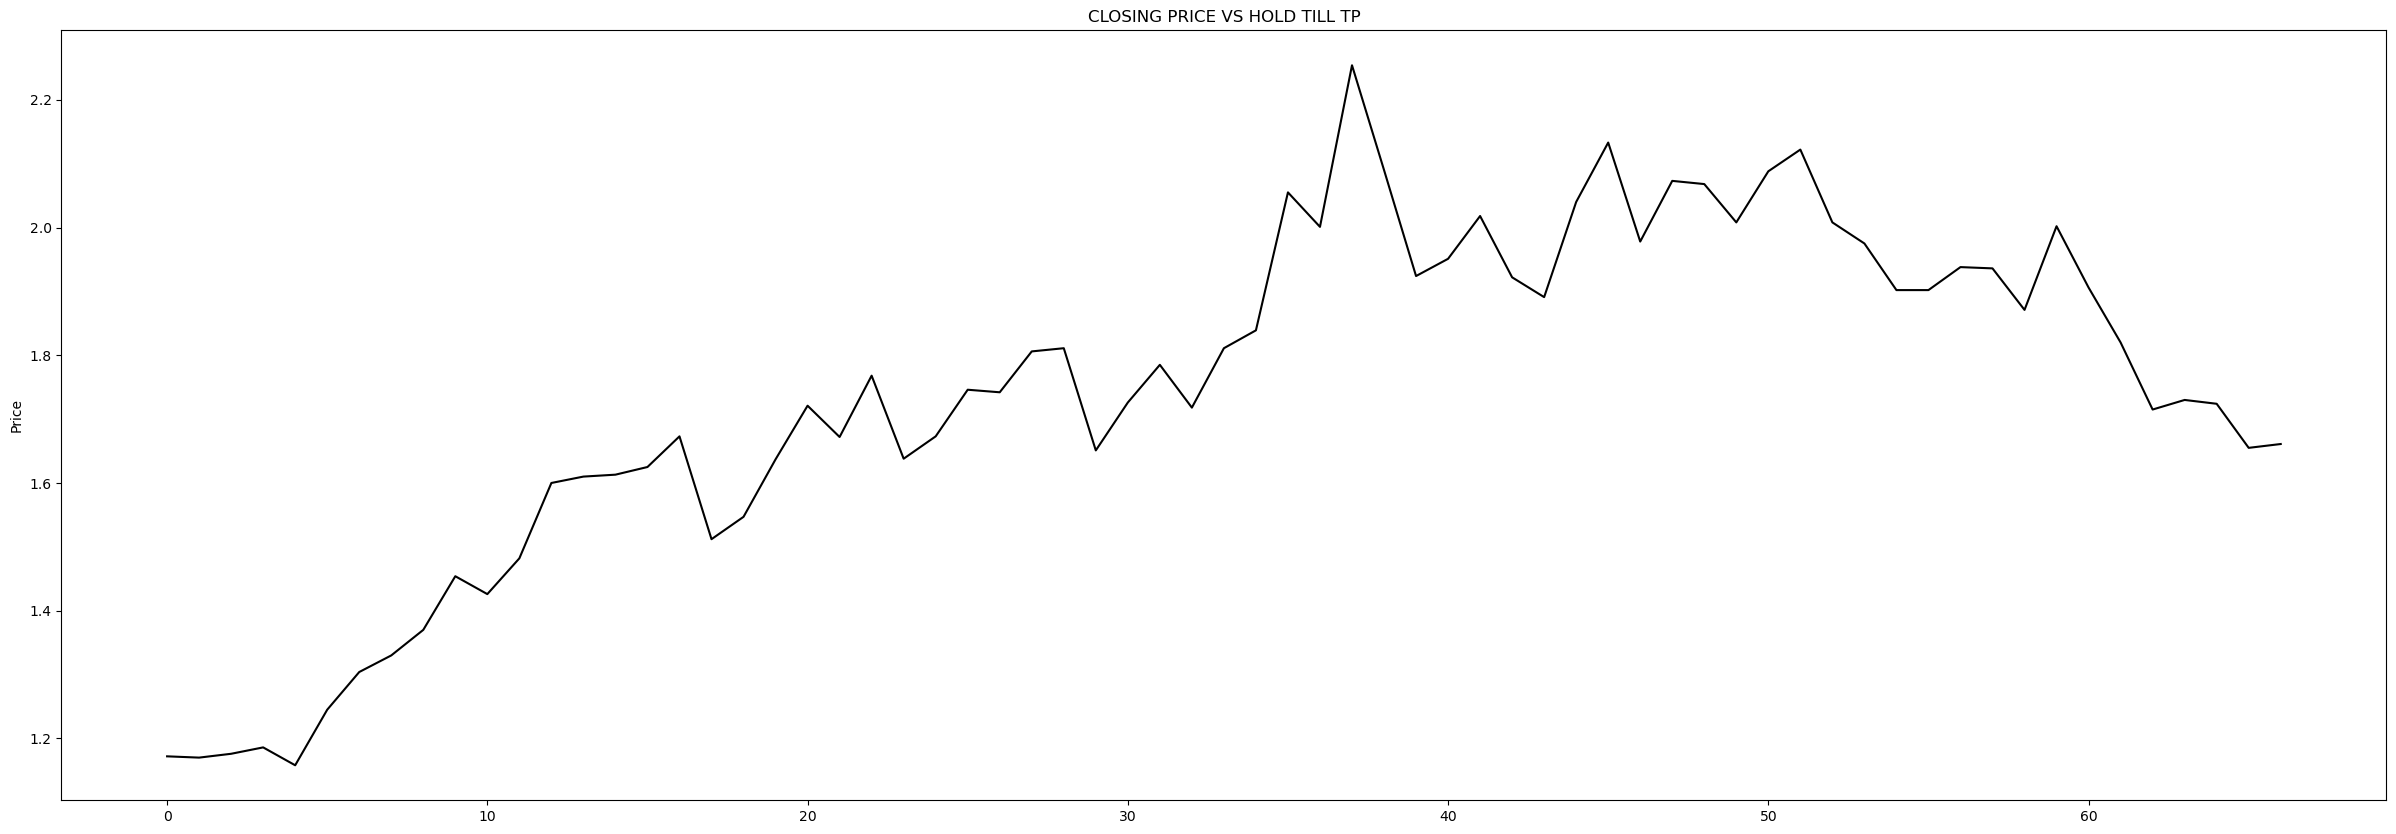

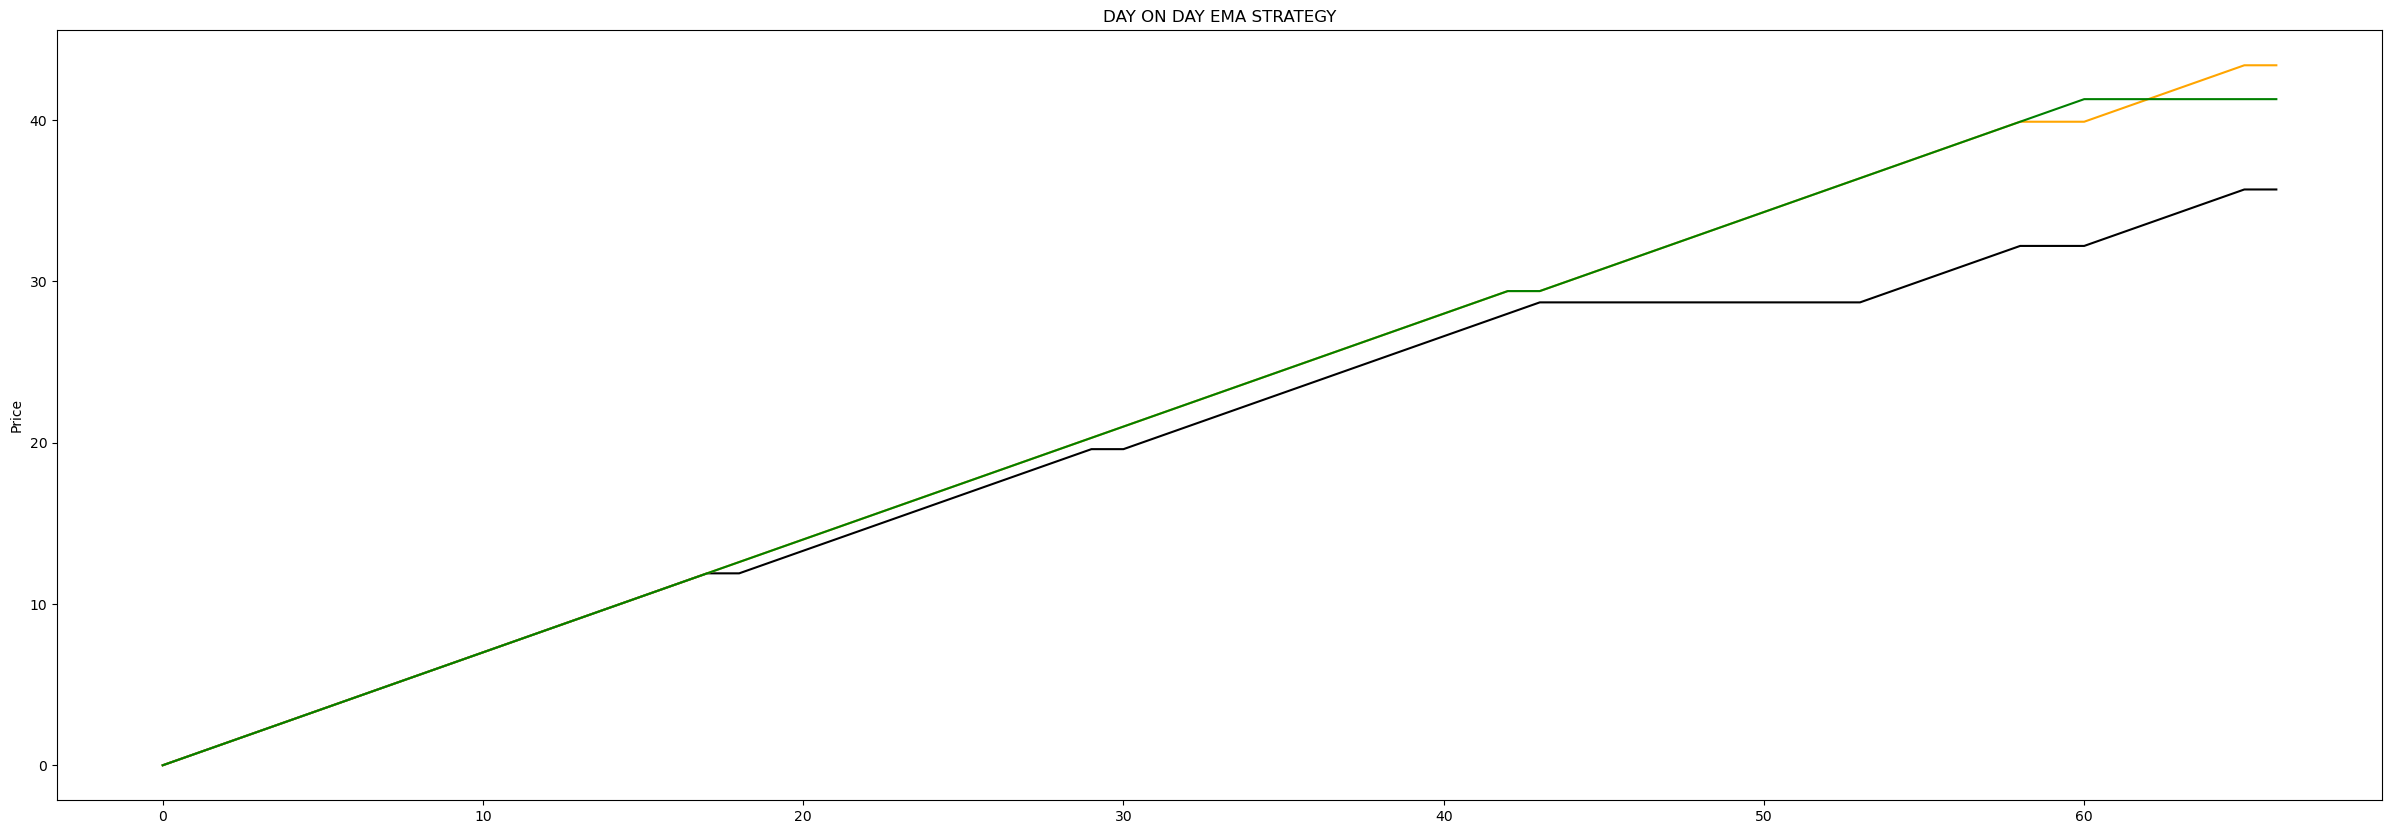

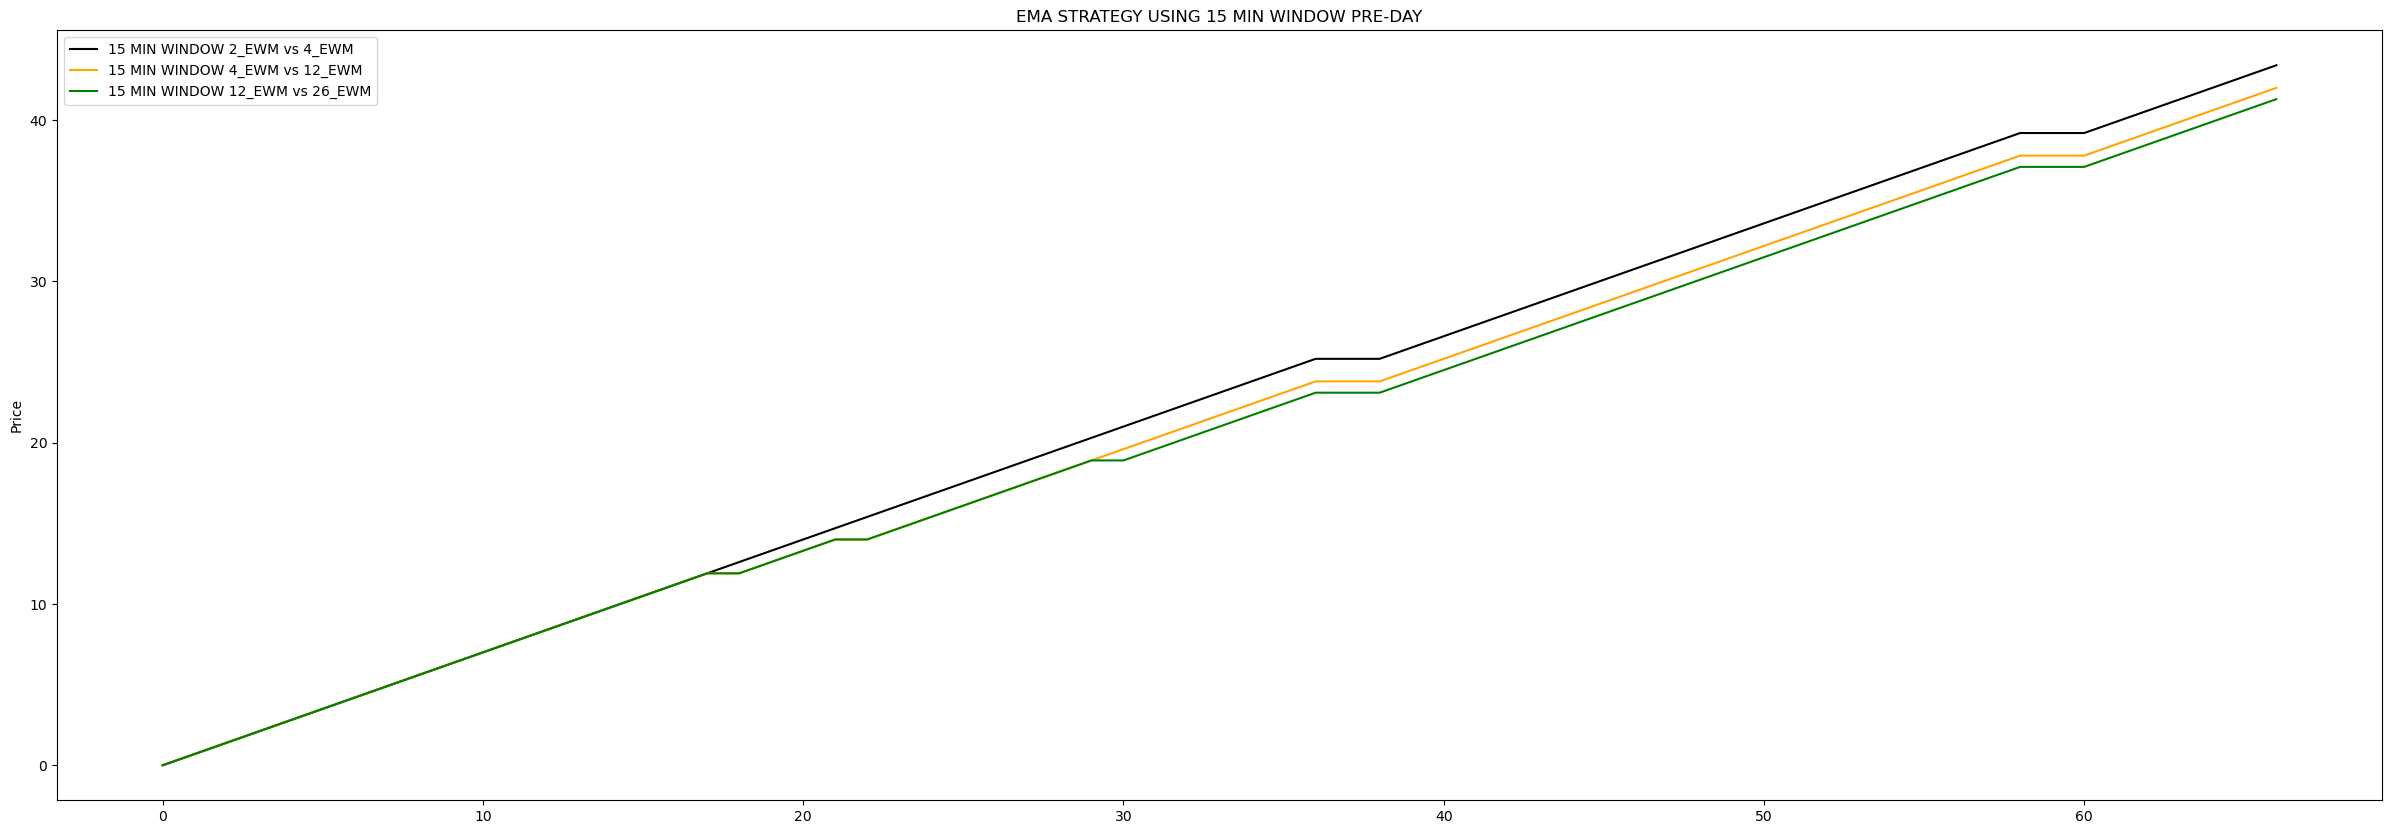

In [21]:

############################ CONDITIONS ############################################################################################################


COINS       = ['RLCUSDT', 'BTCUSDT', 'ADAUSDT', 'GMTUSDT']
PERFORMANCE = {"RLCUSDT - 2023 - 1%"    : "50",
               "RLCUSDT - 2023 - 0.5%"  : "30",
               "RLCUSDT - 2022 - 1%"    : "175",
               "RLCUSDT - 2022 - 0.5%"  : "130",
              
               "BTCUSDT - 2023 - 1%"    : "30",
               "BTCUSDT - 2023 - 0.5%"  : "25",
               "BTCUSDT - 2022 - 1%"    : "0",
               "BTCUSDT - 2022 - 0.5%"  : "50",

               "GMTUSDT - 2023 - 1%"    : "35",
               "GMTUSDT - 2023 - 0.5%"  : "25",
               "GMTUSDT - 2022 - 1%"    : "180",
               "GMTUSDT - 2022 - 0.5%"  : "120",

               "ADAUSDT - 2023 - 1%"    : "28",
               "ADAUSDT - 2023 - 0.5%"  : "25",
               "ADAUSDT - 2022 - 1%"    : "175",
               "ADAUSDT - 2022 - 0.5%"  : "140"}

#DIRECTIONAL_OPTIONS            = ['EMA_DIRECTION', 'EMA_DIRECTION_SHORT_INTERVALS']
#EMA_LIST                       = ['2_EWM', '4_EWM', '12_EWM', '26_EWM']
#df_test['BAH__OUTPUT_TOTAL' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])] 

#BAH__OUTPUT_TOTALEMA_DIRECTION2_EWM vs 4_EWM
#BAH__OUTPUT_TOTALEMA_DIRECTION_SHORT_INTERVALS2_EWM vs 4_EWM

COIN               = COINS[0]
YEAR               = '2023'
TAKE_PROFIT_USE    = 0.7
ROOT                = (r'/Users/westhomas/Desktop/PYTHON/CRYPTO PROJECT/INPUT FILES/INDICATORS')

df_test, df_output_newest = FULL_RUN(COIN, YEAR, ROOT, TAKE_PROFIT_USE)


In [89]:
C = 1   #DIRECTIONAL OPTIONS
A = 1   #EMA LIST
B = 2

df_final = CONVERT_TO_BACKTEST_FORMAT(df_test, TAKE_PROFIT_USE, A, B, C)



[17, 24, 35]


In [57]:
def CONVERT_TO_BACKTEST_FORMAT(df_tv, TAKE_PROFIT_USE, A, B, c):

    TP                     = TAKE_PROFIT_USE
    TRADE_NBR              = 1
    
    DIRECTIONAL_OPTIONS    = ['EMA_DIRECTION', 'EMA_DIRECTION_SHORT_INTERVALS']
    EMA_LIST               = ['2_EWM', '4_EWM', '12_EWM', '26_EWM']
    
    df_tv                  = df_test[['OPEN', 'HIGH','LOW', 'CLOSE','OPEN - LOW (%)','OPEN - HIGH (%)', (str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])),('BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B]))]].rename({(str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])): 'SIGNAL', ('BAH__UPDATE' + str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])):'OUTPUT'}, axis=1)
    df_tv                  = df_tv.reset_index()
    df_tv['POSITION_OPEN'] = ""
    df_tv['TP']            = ""
    df_tv['TP_%']          = TP
    df_tv['TRADE_NBR']     = ""
    df_tv['DRAWDOWN']      = ""
    df_tv['DRAWDOWN_%']    = ""


    for i in range(len(df_tv)):
        if df_tv.at[i, 'OUTPUT'] == 'SHORT OPEN - SUCCESS' or df_tv.at[i, 'OUTPUT'] == 'LONG OPEN - SUCCESS':
            if df_tv.at[i-1, 'OUTPUT'] == 'SHORT OPEN - SUCCESS' or df_tv.at[i-1, 'OUTPUT'] == 'LONG OPEN - SUCCESS' or df_tv.at[i-1, 'OUTPUT'] == '--------':
                df_tv.at[i, 'POSITION_OPEN'] = df_tv.at[i, 'OPEN']
                df_tv.at[i, 'TRADE_NBR']     = TRADE_NBR
                TRADE_NBR                    = TRADE_NBR + 1

        if df_tv.at[i, 'OUTPUT'] == 'SHORT OPEN - INCOMPLETE' or df_tv.at[i, 'OUTPUT'] == 'LONG OPEN - INCOMPLETE':
            if df_tv.at[i-1, 'OUTPUT'] == 'SHORT OPEN - SUCCESS' or df_tv.at[i-1, 'OUTPUT'] == 'LONG OPEN - SUCCESS' or df_tv.at[i-1, 'OUTPUT'] == '--------':
                df_tv.at[i, 'POSITION_OPEN'] = df_tv.at[i, 'OPEN']
                df_tv.at[i, 'TRADE_NBR']     = TRADE_NBR

        if df_tv.at[i, 'OUTPUT'] == 'SHORT OPEN - INCOMPLETE' or df_tv.at[i, 'OUTPUT'] == 'SHORT OPEN - SUCCESS':
            if df_tv.at[i-1, 'OUTPUT'] == 'SHORT OPEN - INCOMPLETE':
                df_tv.at[i, 'POSITION_OPEN'] = df_tv.at[i-1, 'POSITION_OPEN']  
                df_tv.at[i, 'TRADE_NBR']     = TRADE_NBR

                if df_tv.at[i, 'OUTPUT'] == 'SHORT OPEN - SUCCESS':
                    TRADE_NBR                = TRADE_NBR + 1

        if df_tv.at[i, 'OUTPUT'] == 'LONG OPEN - INCOMPLETE' or df_tv.at[i, 'OUTPUT'] == 'LONG OPEN - SUCCESS':
            if df_tv.at[i-1, 'OUTPUT'] == 'LONG OPEN - INCOMPLETE':
                df_tv.at[i, 'POSITION_OPEN'] = df_tv.at[i-1, 'POSITION_OPEN'] 
                df_tv.at[i, 'TRADE_NBR']     = TRADE_NBR

                if df_tv.at[i, 'OUTPUT'] == 'LONG OPEN - SUCCESS':
                    TRADE_NBR                = TRADE_NBR + 1            

    for i in range(len(df_tv)):
        if 'SHORT' in df_tv.at[i, 'OUTPUT']:
            df_tv.at[i, 'TP']         = df_tv.at[i, 'POSITION_OPEN'] * 1 - (TP/100)
            df_tv.at[i, 'DRAWDOWN']   = df_tv.at[i, 'POSITION_OPEN'] - df_tv.at[i, 'HIGH']
            df_tv.at[i, 'DRAWDOWN_%'] = round(((df_tv.at[i, 'POSITION_OPEN'] - df_tv.at[i, 'HIGH']) / df_tv.at[i, 'POSITION_OPEN'])*100,2) 

        elif 'LONG' in df_tv.at[i, 'OUTPUT']:
            df_tv.at[i, 'TP']         = df_tv.at[i, 'POSITION_OPEN'] * 1 + (TP/100)
            df_tv.at[i, 'DRAWDOWN']   = df_tv.at[i, 'POSITION_OPEN'] - df_tv.at[i, 'LOW']
            df_tv.at[i, 'DRAWDOWN_%'] = round(((df_tv.at[i, 'LOW'] - df_tv.at[i, 'POSITION_OPEN']) / df_tv.at[i, 'POSITION_OPEN'])*100,2)                                                    

    GROUP_DF                   = df_tv.groupby(['TRADE_NBR']).agg({'DRAWDOWN':'max', 'DRAWDOWN_%':'max'})
    GROUP_DF                   = GROUP_DF.reset_index()

    del df_tv['DRAWDOWN']
    del df_tv['DRAWDOWN_%']

    df_tv                      = pd.merge(df_tv, GROUP_DF, how="outer", on=['TRADE_NBR'])
    df_out                     = df_tv[['TRADE_NBR', 'DATE', 'POSITION_OPEN', 'TP_%', 'DRAWDOWN_%', 'OUTPUT']].rename({'TRADE_NBR': 'Trade #', 'DATE':'Date/Time', 'POSITION_OPEN':'Price USDT', 'TP_%':'Profit %', 'DRAWDOWN_%':'Drawdown %'}, axis=1)

    df_out['Type']             = ""
    df_out['Signal']           = ""
    df_out['Contracts']        = ""
    df_out['Profit USDT']      = ""
    df_out['Cum. Profit USDT'] = ""
    df_out['Cum. Profit %']    = ""
    df_out['Run-up USDT']      = ""
    df_out['Run-up %']         = ""
    df_out['Drawdown USDT']    = ""

    df_out = df_out[['Trade #', 'Type', 'Signal', 'Date/Time', 'Price USDT', 'Contracts', 'Profit USDT', 'Profit %', 'Cum. Profit USDT', 'Cum. Profit %', 'Run-up USDT', 'Run-up %', 'Drawdown USDT', 'Drawdown %', 'OUTPUT']]
    df_out['COUNT']  = ""

    J = 1

    for i in range(len(df_out)):
        if i == 0:
            df_out.at[i, 'COUNT']  = J        

        elif df_out.at[i, 'Trade #'] != df_out.at[i-1, 'Trade #']:
            J = 1
            df_out.at[i, 'COUNT']  = J

        elif df_out.at[i, 'Trade #'] == df_out.at[i-1, 'Trade #']:
            J = J + 1
            df_out.at[i, 'COUNT']  = J


    df_out                       = df_out.iloc[1:]    
    TRADES                       = df_out['Trade #'].max()       
    GROUP_DF_2                   = df_out.groupby(['Trade #']).agg({'COUNT':'max'})
    GROUP_DF_2                   = GROUP_DF_2.reset_index()

    del df_out['COUNT']

    df_out                      = pd.merge(df_out, GROUP_DF_2, how="outer", on=['Trade #'])
    

    df_final                    = df_out[df_out['COUNT']==1]
    df_final                    = df_final.append(df_final)
    df_temp                     = df_out[df_out['COUNT']==2]
    df_final                    = df_final.append(df_temp)
    df_temp                     = df_out[df_out['COUNT']>2].reset_index().iloc[:,1:]
    list_unique                 = df_temp["Trade #"].unique().tolist()

    print(list_unique)

    if len(list_unique) != 1:
        for k in range(len(list_unique)):
            df_temp_iter  = df_temp[df_temp['Trade #']==list_unique[k]].reset_index().iloc[:,1:]
            df_temp_first = df_temp_iter.iloc[0, :]
            df_temp_last  = df_temp_iter.iloc[len(df_temp_iter)-1, :]
            df_final      = df_final.append(df_temp_first)
            df_final      = df_final.append(df_temp_last)        

    else:
        df_temp_first = df_temp.iloc[0, :]
        df_temp_last  = df_temp.iloc[len(df_temp)-1, :]
        df_final      = df_final.append(df_temp_first)
        df_final      = df_final.append(df_temp_last)

    df_final        = df_final.sort_values(by=['Date/Time'], ascending=True).reset_index().iloc[:, 1:]
    LONG_SHORT_LIST = []

    for i in range(len(df_final)):
        if (i % 2) == 0:
            if 'SHORT' in df_final.at[i, 'OUTPUT']:
                VAL = 'ENTRY SHORT'
            elif 'LONG' in df_final.at[i, 'OUTPUT']:
                VAL = 'ENTRY LONG'            
        else:
            if 'SHORT' in df_final.at[i, 'OUTPUT']:
                VAL = 'EXIT SHORT'
            elif 'LONG' in df_final.at[i, 'OUTPUT']:
                VAL = 'EXIT LONG'             

        LONG_SHORT_LIST.append(VAL)

    df_final['Type'] = LONG_SHORT_LIST

    del df_final['OUTPUT']
    del df_final['COUNT']

    df_final['Drawdown %'] = df_final['Drawdown %'] * -1
 
        
   

    df_final.to_csv(ROOT + '/' + '1 DAY STRATEGY - BUY & HOLD TP  (' + str(TAKE_PROFIT_USE) + '%) - ' + COIN + ' (' + (str(DIRECTIONAL_OPTIONS[c]) + str(EMA_LIST[A]) + ' vs ' + str(EMA_LIST[B])) +') - ' + YEAR + '.csv') 

    return df_final

    
    
    

